# Heart Failure Prediction Dataset
Data Sources:

1.- Primary Data:   https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data

2.- Observations:
  Data Quality Ensuring accuracy reliability and validity.

> Add blockquote



# Data Collection

In [1]:
# Installations
#!pip install catboost
#!pip install xgboost
#!pip install lightgbm

# imports
import pandas as pd
import kagglehub
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#store data into drive in an specific folder
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/DataManagement2024/HeartFailureData/heart.csv"
raw_heart_df = pd.read_csv(filepath)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
raw_heart_df.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


In [4]:
raw_heart_df.tail(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In [5]:
raw_heart_df.shape

(918, 12)

In [6]:
raw_heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Attribute Information

Categorical:
* Sex: {'F', 'M'} sex of the patient [M: Male, F: Female]

* Chest Pain Type (disconfort): {'ATA', 'ASY', 'TA', 'NAP'}  chest pain type
[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

* Fasting BS: {0, 1} fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

* RestingECG: {'Normal', 'ST', 'LVH'}  resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

* Exercises Angina: {'N', 'Y'} exercise-induced angina [Y: Yes, N: No]

* ST_Slope: {'Up', 'Flat', 'Down'}  the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

* HeartDisease: {0, 1} output class [1: heart disease, 0: Normal]

Numeric:
* Age: age of the patient [years]
* RestingBP (measurement): resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* Oldpeak: ST [Numeric value measured in depression]


# Data Cleaning and preparation

In [7]:
numerical_columns = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
categorical_columns = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope','HeartDisease']

## Duplicate Data

In [8]:
raw_heart_df.duplicated().sum()

0

##  Missing Values

### Missing Values: Numerical Features

In [9]:
# Look for negatives in numerical data
negative_values = (raw_heart_df[numerical_columns] < 0).any()
print(negative_values)

Age            False
RestingBP      False
Cholesterol    False
MaxHR          False
Oldpeak         True
dtype: bool


In [10]:
print(raw_heart_df['Oldpeak'].min(), raw_heart_df['Oldpeak'].max())

-2.6 6.2


### Missing Values: Categorical Features

In [11]:
#categorical variables
print('Sex:',set(raw_heart_df['Sex']))
print('ChestPainType:',set(raw_heart_df['ChestPainType']))
print('FastingBS:',set(raw_heart_df['FastingBS']))
print('RestingECG:',set(raw_heart_df['RestingECG']))
print('ExerciseAngina',set(raw_heart_df['ExerciseAngina']))
print('ST_Slope',set(raw_heart_df['ST_Slope']))
#target
print('HeartDisease',set(raw_heart_df['HeartDisease']))

Sex: {'F', 'M'}
ChestPainType: {'TA', 'ASY', 'ATA', 'NAP'}
FastingBS: {0, 1}
RestingECG: {'Normal', 'LVH', 'ST'}
ExerciseAngina {'N', 'Y'}
ST_Slope {'Up', 'Down', 'Flat'}
HeartDisease {0, 1}


Notes:
  
  Require Potential Hot encoding Sex,ExerciseAngina
  
  Label encoding: ChestPainType, RestingECG, ST_Slope

  No missing values in categorical data.

## Outliers

## Detecting Outliers

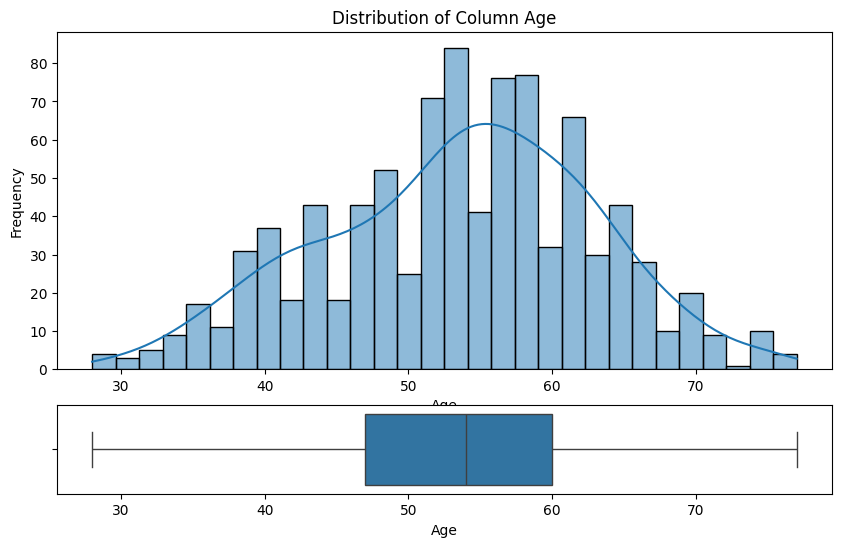

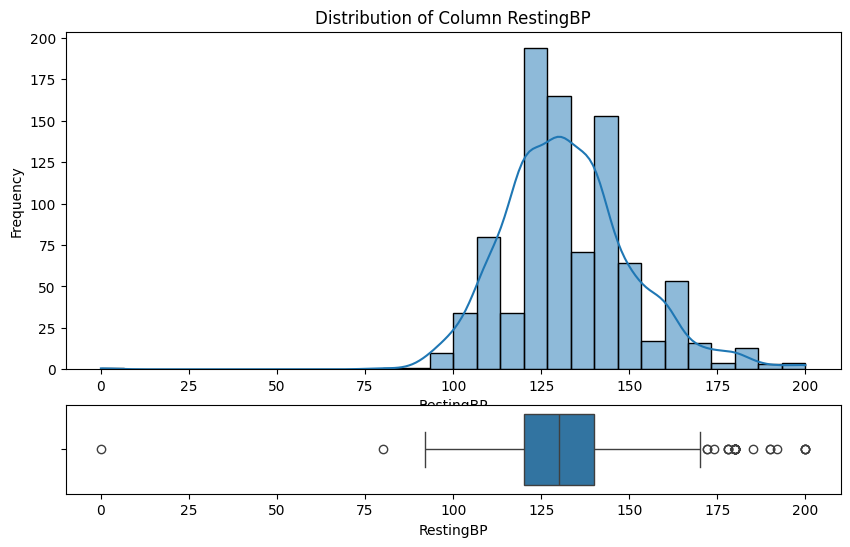

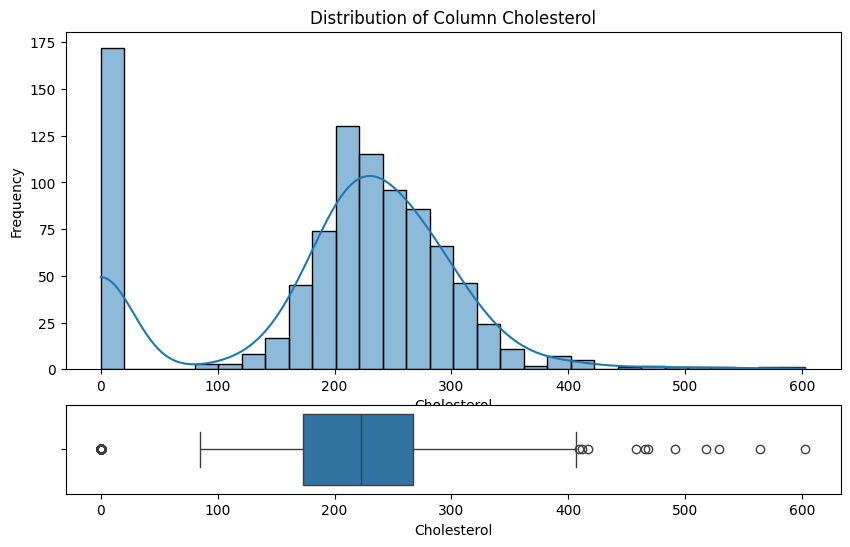

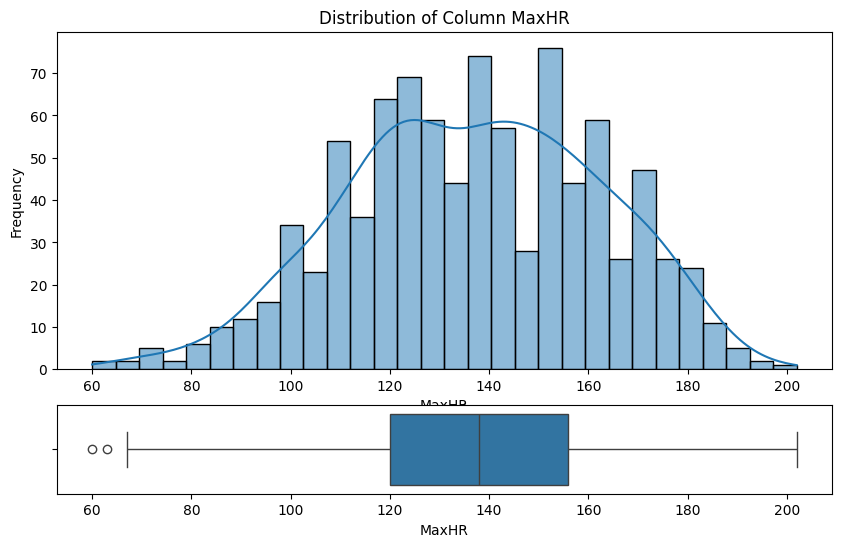

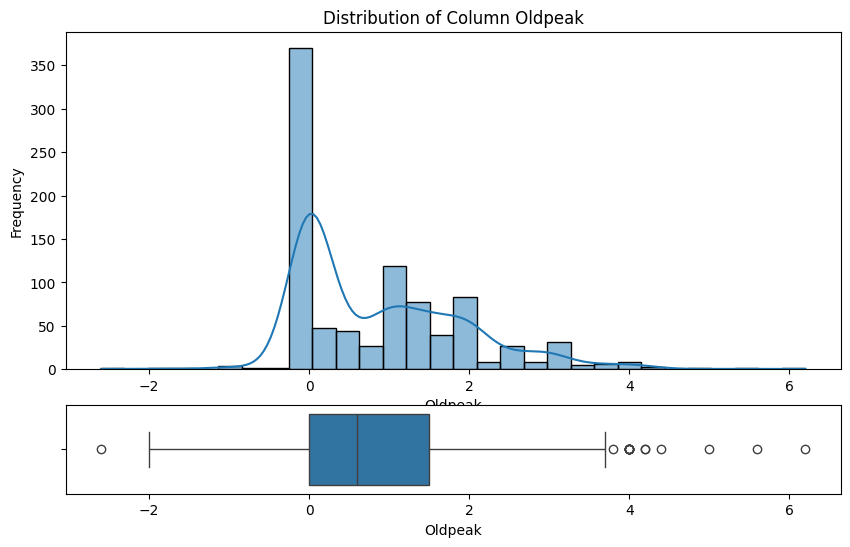

Skewness: -0.19593302867569365
Kurtosis: -0.3861396123864571
The data is approximately symmetric (Gaussian-like).

Skewness: 0.1798393100516288
Kurtosis: 3.2712509168295356
The data is approximately symmetric (Gaussian-like).

Skewness: -0.6100864307268192
Kurtosis: 0.11820846851766742
The data is skewed.

Skewness: -0.14435941846180994
Kurtosis: -0.4482478199521531
The data is approximately symmetric (Gaussian-like).

Skewness: 1.0228720218107528
Kurtosis: 1.2030636840120112
The data is skewed.



In [12]:
def check_distr_outliers(df, column):
  # Histogram and boxplot to visualize outliers
  data = df[column]

  # Create a figure with subplots
  fig = plt.figure(figsize=(10, 6))
  grid = plt.GridSpec(4, 1, hspace=0.4)

  # Add a histogram in the first subplot
  ax_hist = fig.add_subplot(grid[:-1, 0])
  sns.histplot(data, bins=30, kde=True, ax=ax_hist)
  ax_hist.set_ylabel('Frequency')
  ax_hist.set_title('Distribution of Column '+column)

  # Add a horizontal box plot in the second subplot
  ax_box = fig.add_subplot(grid[-1, 0])
  sns.boxplot(data, ax=ax_box, orient='h')
  ax_box.set_xlabel(column)

  # Show the plot
  plt.show()
check_distr_outliers(raw_heart_df,'Age')
check_distr_outliers(raw_heart_df,'RestingBP')
check_distr_outliers(raw_heart_df,'Cholesterol')
check_distr_outliers(raw_heart_df,'MaxHR')
check_distr_outliers(raw_heart_df,'Oldpeak')


def check_outliers(df, column):
  print("Skewness:", df[column].skew())
  print("Kurtosis:", df[column].kurt())
  if abs(df[column].skew()) < 0.5:
      print("The data is approximately symmetric (Gaussian-like).\n")
  else:
      print("The data is skewed.\n")

check_outliers(raw_heart_df,'Age')
check_outliers(raw_heart_df,'RestingBP')
check_outliers(raw_heart_df,'Cholesterol')
check_outliers(raw_heart_df,'MaxHR')
check_outliers(raw_heart_df,'Oldpeak')

### Missing Values and Outliers Notes.

Normal Distribution: Age, RestingBP, Cholesterol, MaxHR.


### Asumptions for Inconsistencies in the data:

1.- Resting BP:   Systolic Measurement  (<70,>200)

  Inconsistencies to Flag in RestingBP:
  - Too Low:
    Systolic <70 mm Hg or Diastolic <40 mm Hg is likely unrealistic or represents severe hypotension that would likely require medical attention.
    Values below these thresholds should be flagged for verification.
  - Too High:
    Systolic >200 mm Hg or Diastolic >120 mm Hg is extremely rare and may indicate severe hypertension or data entry errors.
    Flag values exceeding these thresholds for review.
    Biologically Impossible Values:
    Negative or Zero Values: Blood pressure cannot be zero or negative; these should be removed or corrected.
    
2.- Cholesterol: (<100,>600) Total Cholesterol
  
  Potential Errors or Inconsistencies:
  - Too Low:
    Values '<'100 mg/dL are rare and may indicate:
    Data entry errors.
    Severe malnutrition or metabolic disorders (e.g., hypocholesterolemia).
  - Too High:
    Values >600 mg/dL are uncommon and may reflect:
    Genetic conditions like familial hypercholesterolemia.
    Severe data inconsistencies if >1,200 mg/dL.
    Unrealistic or Biologically Impossible Values:
    Negative values or values >1,200 mg/dL are biologically impossible and must be corrected.

3.- Maximum Heart Rate (MaxHR): (<100, >220)

  Outliers to Flag:
    - Too High: Values > 220 bpm are generally unrealistic unless the person is very young or in a rare extreme case.
    - Too Low: Values < 100 bpm are unlikely for MaxHR unless severe cardiovascular conditions or errors exist.
    HR < 30 bpm is life-threatening and warrants immediate medical attention.

4.- OldPeak: (<0, >5)

  Inconsistencies to Flag:
    - Negative Oldpeak Values:
    Negative values (<0 mm) are biologically inconsistent for ST depression or elevation unless your dataset explicitly includes them to represent elevation in another context.
    - Extreme Positive Values:
    Values >5 mm are extremely rare and may indicate a data entry error unless explicitly verified by clinical context.


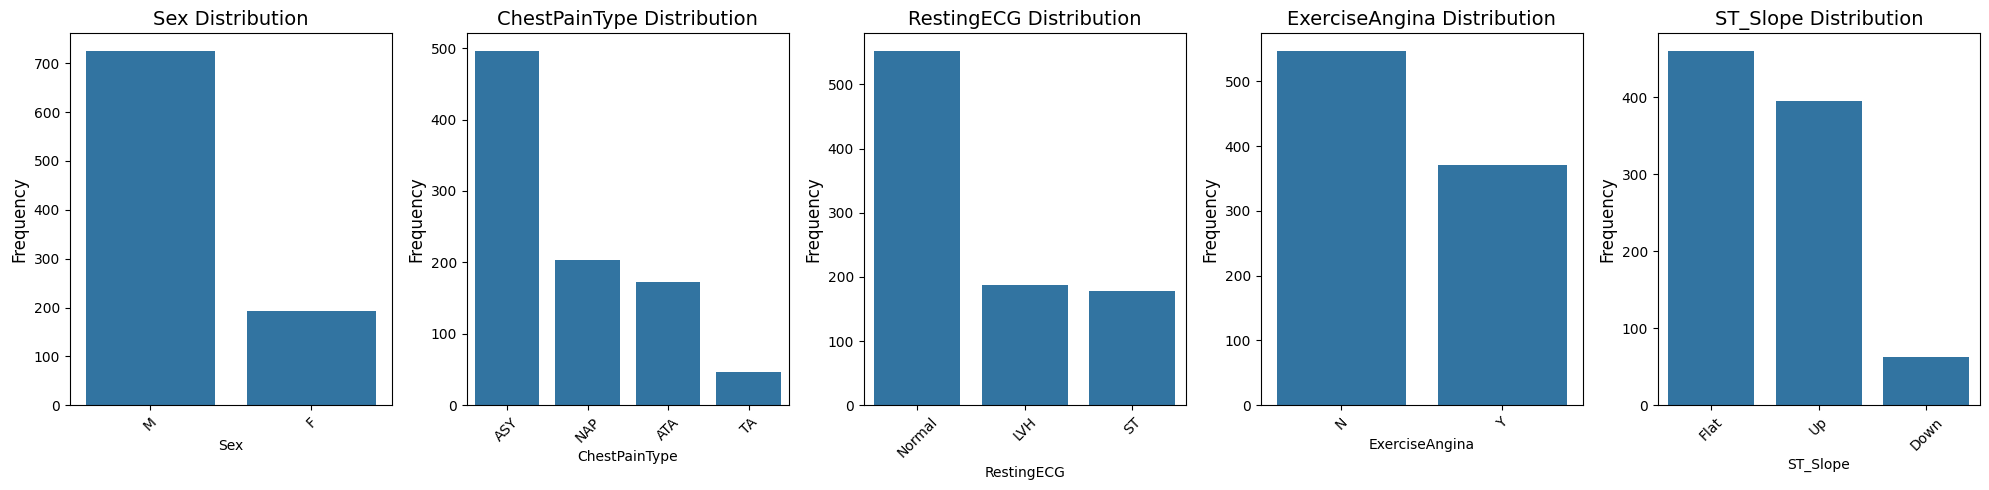

In [13]:
def plot_frequency_distribution(df):
  # Select categorical columns
  categorical_columns = df.select_dtypes(include=['object', 'category']).columns

  # Define maximum plots per row
  max_plots_per_row = 5

  # Number of rows needed
  num_cols = len(categorical_columns)
  num_rows = (num_cols // max_plots_per_row) + (num_cols % max_plots_per_row > 0)

  # Create subplots
  fig, axes = plt.subplots(num_rows, max_plots_per_row, figsize=(20, num_rows * 5))
  axes = axes.flatten()  # Flatten to simplify indexing

  # Plot each categorical variable
  for i, col in enumerate(categorical_columns):
      category_counts = df[col].value_counts()  # Get category frequencies
      sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i])
      axes[i].set_title(f'{col} Distribution', fontsize=14)

      axes[i].set_ylabel('Frequency', fontsize=12)
      axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

  # Hide unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

plot_frequency_distribution(raw_heart_df)

## Inconsistencies

In [14]:
df = raw_heart_df.copy()

# Check categorical distribution for all object or categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"--- {col} ---")
    counts = df[col].value_counts()  # Frequency
    percentages = df[col].value_counts(normalize=True) * 100  # Percentage
    print(pd.DataFrame({'Count': counts, 'Percentage': percentages}).sort_values(by='Count', ascending=False))
    print("\n")


--- Sex ---
     Count  Percentage
Sex                   
M      725   78.976035
F      193   21.023965


--- ChestPainType ---
               Count  Percentage
ChestPainType                   
ASY              496   54.030501
NAP              203   22.113290
ATA              173   18.845316
TA                46    5.010893


--- RestingECG ---
            Count  Percentage
RestingECG                   
Normal        552   60.130719
LVH           188   20.479303
ST            178   19.389978


--- ExerciseAngina ---
                Count  Percentage
ExerciseAngina                   
N                 547   59.586057
Y                 371   40.413943


--- ST_Slope ---
          Count  Percentage
ST_Slope                   
Flat        460   50.108932
Up          395   43.028322
Down         63    6.862745




Notes: Imbalanced Columns: Sex

Notes: No duplicated data.
No datatype transformation required.

# Statistical Summary

In [15]:
# Numeric Variables
raw_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


# EDA -  Bivariate Analysis

### Numerical vs Numerical

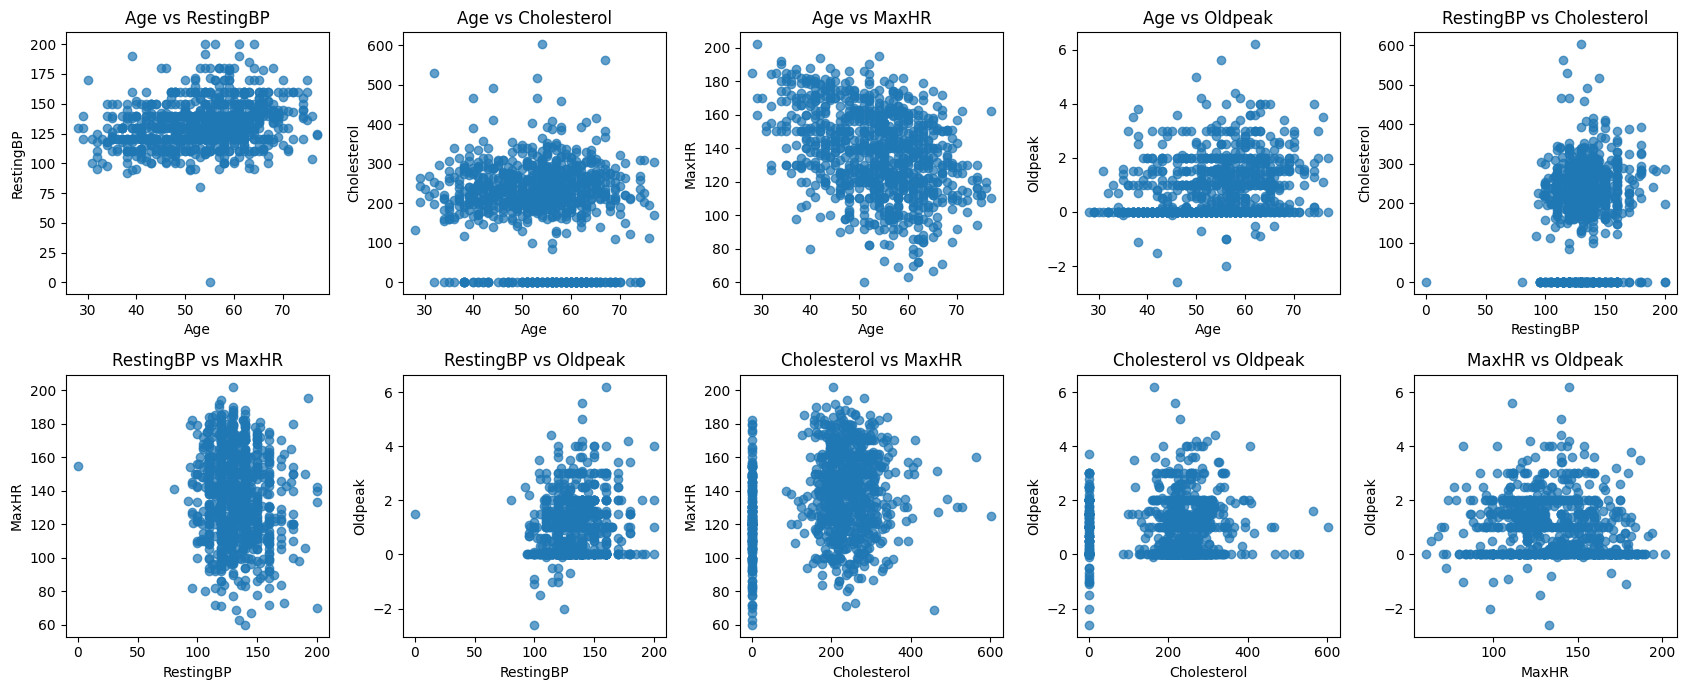

In [16]:
import itertools
def plot_scatter_matrix(df):
  # Create a sample dataset for demonstration
  np.random.seed(42)


  # Define the columns and generate all 2-combinations
  columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
  combinations = list(itertools.combinations(columns, 2))

  # Set up the subplot grid (2 rows, 5 columns)
  fig, axes = plt.subplots(2, 5, figsize=(17, 7))
  axes = axes.flatten()

  # Plot the scatter plots for the first 10 combinations
  for i, (col1, col2) in enumerate(combinations[:10]):
      ax = axes[i]
      ax.scatter(df[col1], df[col2], alpha=0.7)
      ax.set_xlabel(col1)
      ax.set_ylabel(col2)
      ax.set_title(f'{col1} vs {col2}')

  # Adjust layout for clarity
  plt.tight_layout()
  plt.show()

plot_scatter_matrix(raw_heart_df.copy())

### Numerical vs Categorical


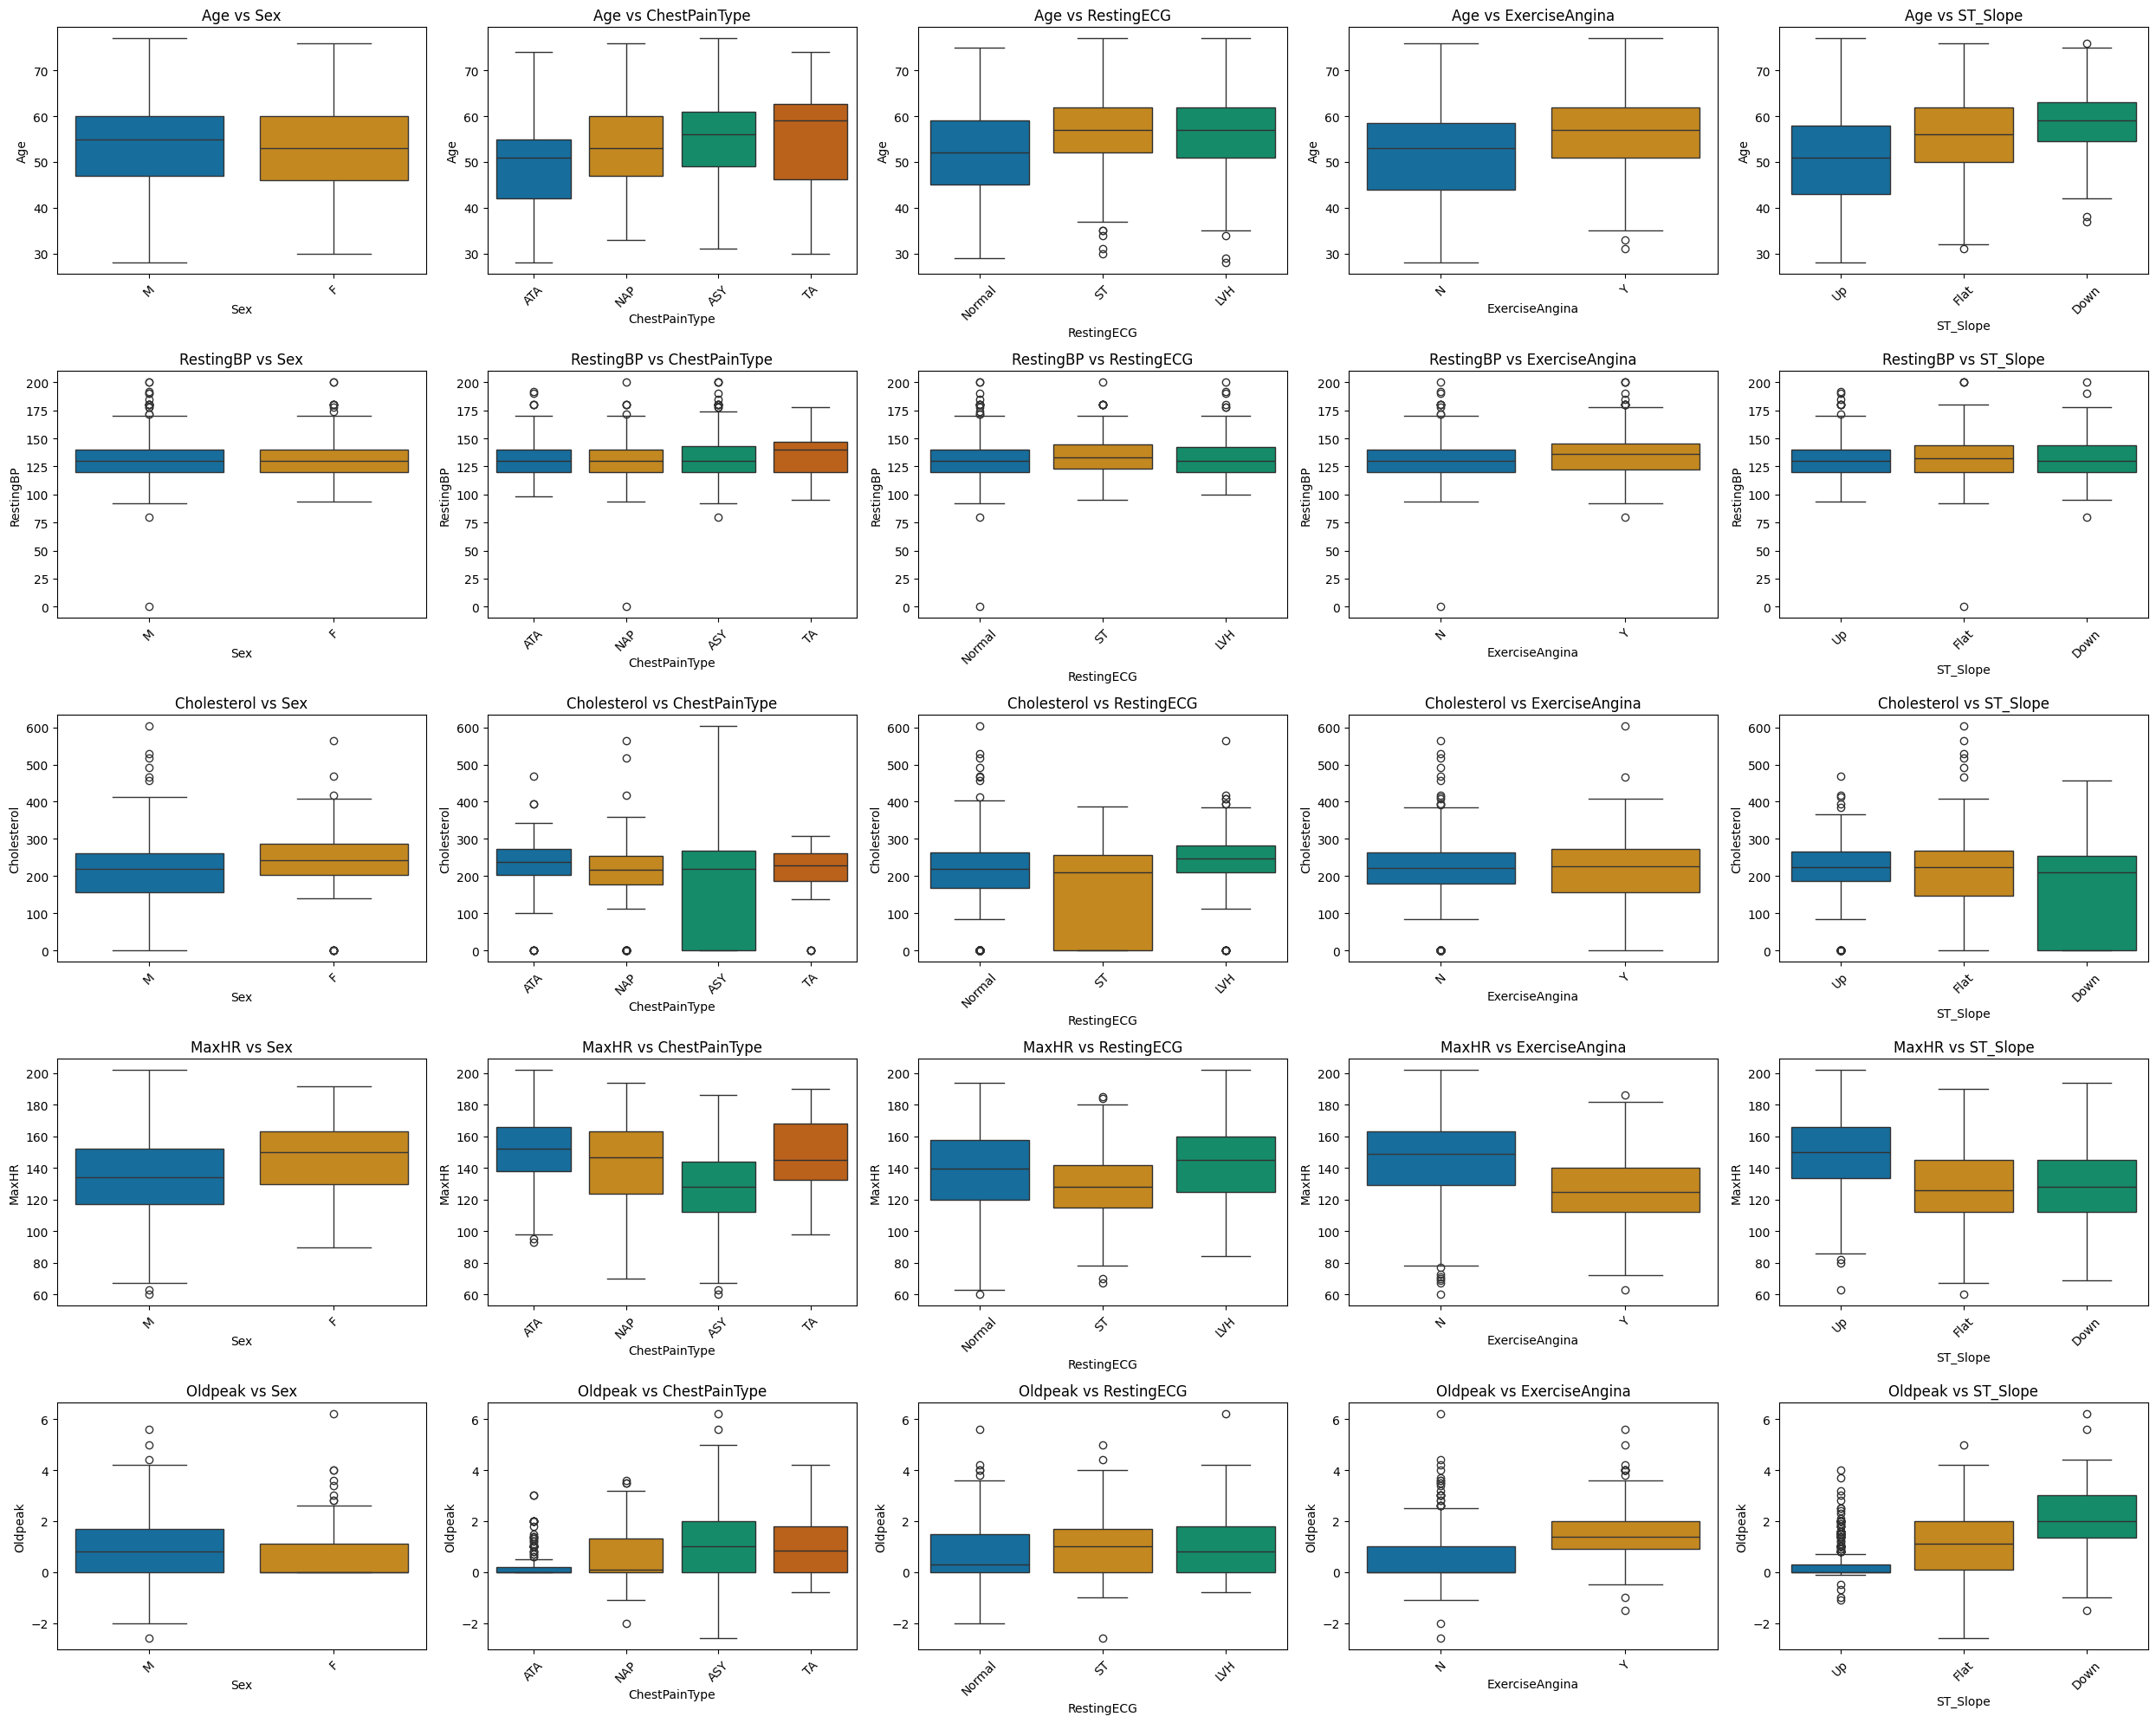

In [17]:
def plot_boxplots(df,numerical_columns,categorical_columns):

  # Define numerical and categorical columns
  numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
  categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

  # Create a figure with a 5x5 grid for 25 plots
  fig, axes = plt.subplots(5, 5, figsize=(25, 20))

  # Plot relationships between numerical and categorical columns
  for i, num_col in enumerate(numerical_columns):
      for j, cat_col in enumerate(categorical_columns):
          ax = axes[i, j]  # Determine subplot location
          sns.boxplot(data=df, x=cat_col, y=num_col, ax=ax, hue=cat_col, dodge=False, palette="colorblind")
          ax.set_title(f'{num_col} vs {cat_col}')
          ax.set_xlabel(cat_col)
          ax.set_ylabel(num_col)
          ax.tick_params(axis='x', rotation=45)
          #ax.legend_.remove()  # Remove redundant legends for clarity

  # Adjust layout
  plt.tight_layout()
  plt.show()
plot_boxplots(raw_heart_df.copy(),numerical_columns,categorical_columns)

### Categorical vs Categorical

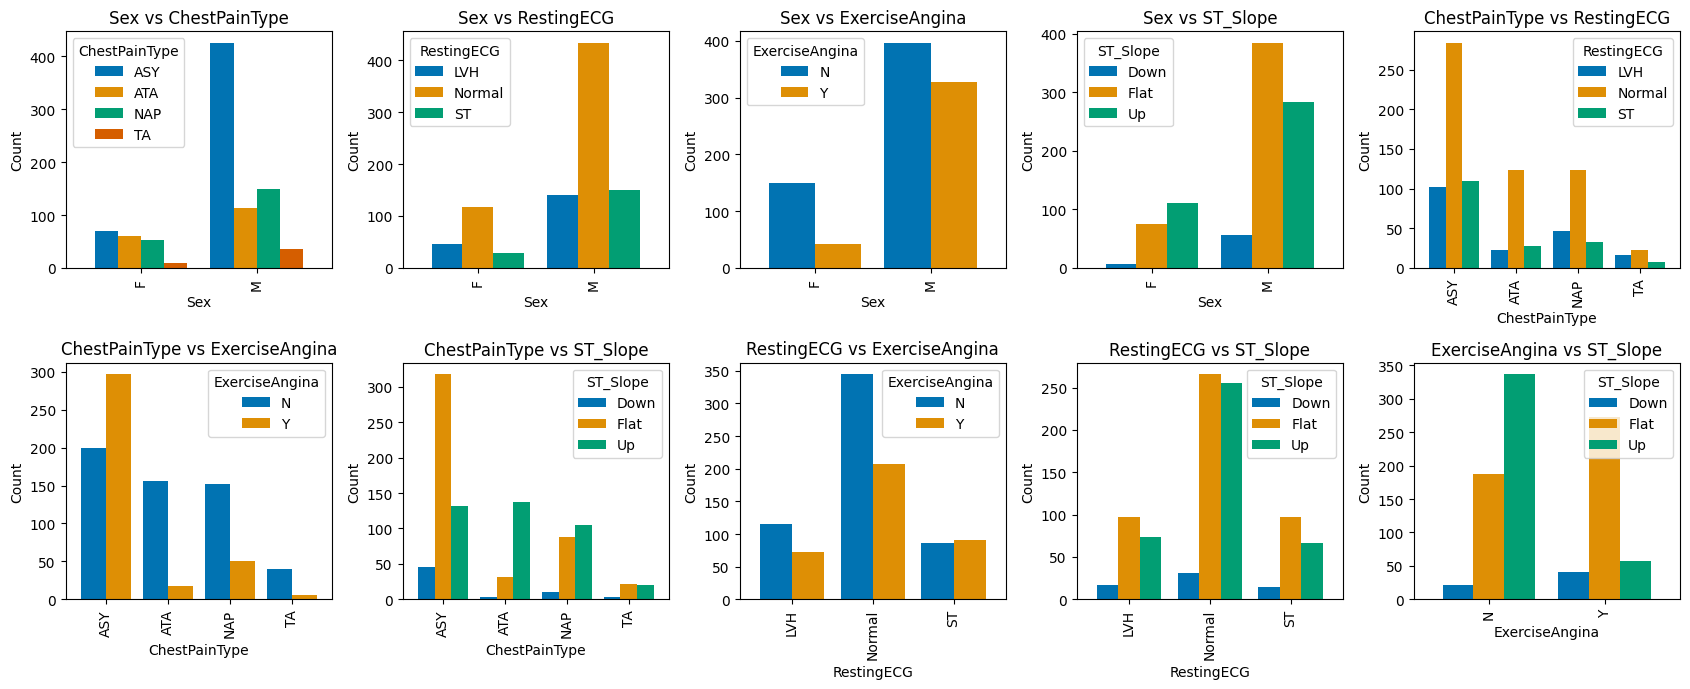

In [18]:
def plot_grouped_stacked_bar_charts(df):
  # Simulate a dataset for demonstration purposes
  np.random.seed(0)


  # Define pairs of columns to create grouped bar charts
  pairs = [
      ('Sex', 'ChestPainType'),
      ('Sex', 'RestingECG'),
      ('Sex', 'ExerciseAngina'),
      ('Sex', 'ST_Slope'),
      ('ChestPainType', 'RestingECG'),
      ('ChestPainType', 'ExerciseAngina'),
      ('ChestPainType', 'ST_Slope'),
      ('RestingECG', 'ExerciseAngina'),
      ('RestingECG', 'ST_Slope'),
      ('ExerciseAngina', 'ST_Slope')
  ]

  # Define a colorblind-friendly palette from Seaborn
  sns_palette = sns.color_palette("colorblind", n_colors=10)

  # Create a figure and axes
  fig, axes = plt.subplots(2, 5, figsize=(17, 7))

  # Plot grouped bar charts for each pair of columns with a colorblind-friendly palette
  for i, (col1, col2) in enumerate(pairs):
      ax = axes[i // 5, i % 5]  # Determine subplot location
      crosstab = pd.crosstab(df[col1], df[col2])
      crosstab.plot(kind='bar', ax=ax, color=sns_palette[:len(crosstab.columns)], legend=True, width=0.8)
      ax.set_title(f'{col1} vs {col2}')
      ax.set_xlabel(col1)
      ax.set_ylabel('Count')
      ax.legend(title=col2, loc='best')

  # Adjust layout
  plt.tight_layout()
  plt.show()

plot_grouped_stacked_bar_charts(raw_heart_df.copy())

# EDA - Multivariate Analysis


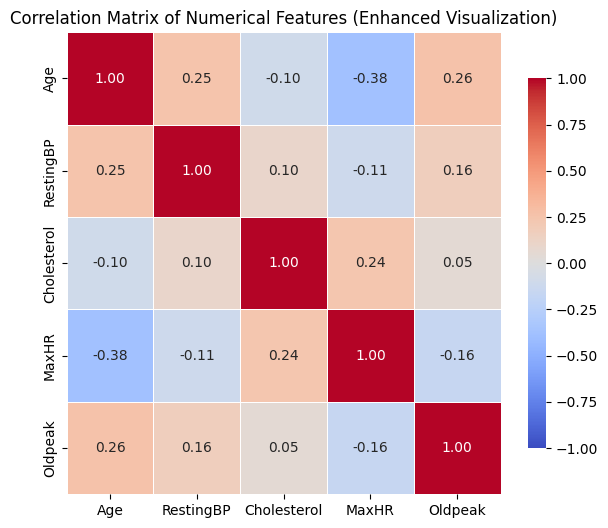

In [19]:
def correlation_plot(df,numerical_columns):
  correlation_matrix = df[numerical_columns].corr()
  # Plot the correlation matrix as a heatmap with a new color palette
  plt.figure(figsize=(7, 6))
  sns.heatmap(
      correlation_matrix,
      annot=True,
      cmap="coolwarm",  # High-contrast color palette
      fmt=".2f",
      vmin=-1,
      vmax=1,
      linewidths=0.5,  # Add gridlines for clarity
      cbar_kws={"shrink": 0.8}  # Adjust the size of the color bar
  )
  plt.title("Correlation Matrix of Numerical Features (Enhanced Visualization)")
  plt.show()
correlation_plot(raw_heart_df.copy(),numerical_columns)

# Data Preprocessing

### Handle Outliers



### Removing Outliers from Resting Blood Pressure


In [20]:
 #Resting BP:   Systolic Measurement  (<70,>200)
def detect_outliers(df, column):

  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  #print(lower_bound,upper_bound)
  return outliers

print('Outliers RestingBP:', len(detect_outliers(raw_heart_df,'RestingBP')))
print('Outliers Cholesterol:', len(detect_outliers(raw_heart_df,'Cholesterol')))
print('Outliers MaxHR:', len(detect_outliers(raw_heart_df,'MaxHR')))
print('Outliers Oldpeak:', len(detect_outliers(raw_heart_df,'Oldpeak')))

Outliers RestingBP: 28
Outliers Cholesterol: 183
Outliers MaxHR: 2
Outliers Oldpeak: 16


In [21]:

def detect_inconsistencies(df, column,lower_bound,upper_bound):
  df_cleaned = df.copy()
  return len(df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)])


def removing_inconsistencies(df, column,lower_bound,upper_bound):
  df_cleaned = df.copy()
  df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] < upper_bound)]
  return df_cleaned

#incorrect recording, unit mismatches, or typographical mistakes.

print('Outliers RestingBP:', detect_inconsistencies(raw_heart_df,'RestingBP',70,200))
print('Outliers Cholesterol:', detect_inconsistencies(raw_heart_df,'Cholesterol',70,1200))
print('Outliers MaxHR:', detect_inconsistencies(raw_heart_df,'MaxHR',20,220))
print('Outliers Oldpeak:', detect_inconsistencies(raw_heart_df,'Oldpeak',0,10))


heart_df_cleaned = raw_heart_df.copy()
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'RestingBP',70,200)
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'Cholesterol',20,1200)
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'MaxHR',20,220)
heart_df_cleaned = removing_inconsistencies(heart_df_cleaned, 'Oldpeak',0,5)


Outliers RestingBP: 1
Outliers Cholesterol: 172
Outliers MaxHR: 0
Outliers Oldpeak: 13


In [22]:
print('Outliers RestingBP:', detect_inconsistencies(heart_df_cleaned,'RestingBP',70,200))
print('Outliers Cholesterol:', detect_inconsistencies(heart_df_cleaned,'Cholesterol',70,1200))
print('Outliers MaxHR:', detect_inconsistencies(heart_df_cleaned,'MaxHR',20,220))
print('Outliers Oldpeak:', detect_inconsistencies(heart_df_cleaned,'Oldpeak',0,10))

Outliers RestingBP: 0
Outliers Cholesterol: 0
Outliers MaxHR: 0
Outliers Oldpeak: 0


In [23]:

print('Outliers RestingBP:', len(detect_outliers(heart_df_cleaned,'RestingBP')))
print('Outliers Cholesterol:', len(detect_outliers(heart_df_cleaned,'Cholesterol')))
print('Outliers MaxHR:', len(detect_outliers(heart_df_cleaned,'MaxHR')))
print('Outliers Oldpeak:', len(detect_outliers(heart_df_cleaned,'Oldpeak')))

Outliers RestingBP: 18
Outliers Cholesterol: 23
Outliers MaxHR: 0
Outliers Oldpeak: 11


In [24]:
heart_df_cleaned.shape


(740, 12)

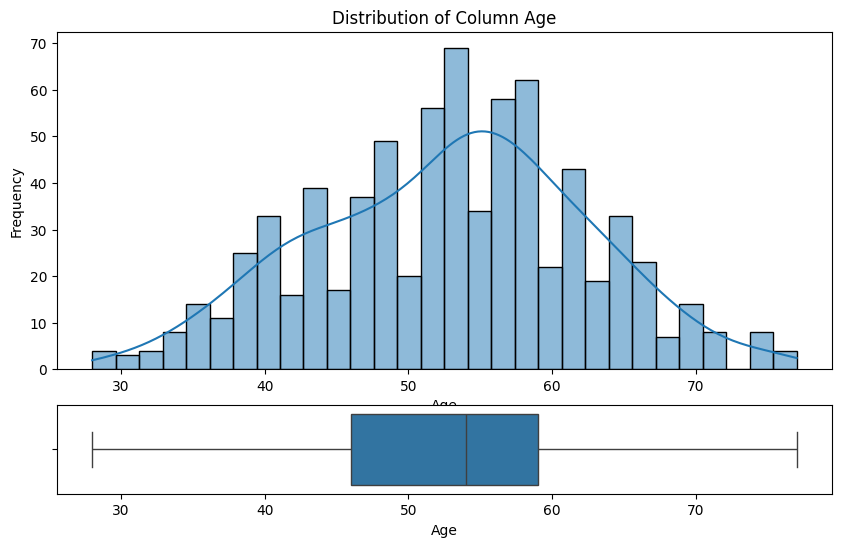

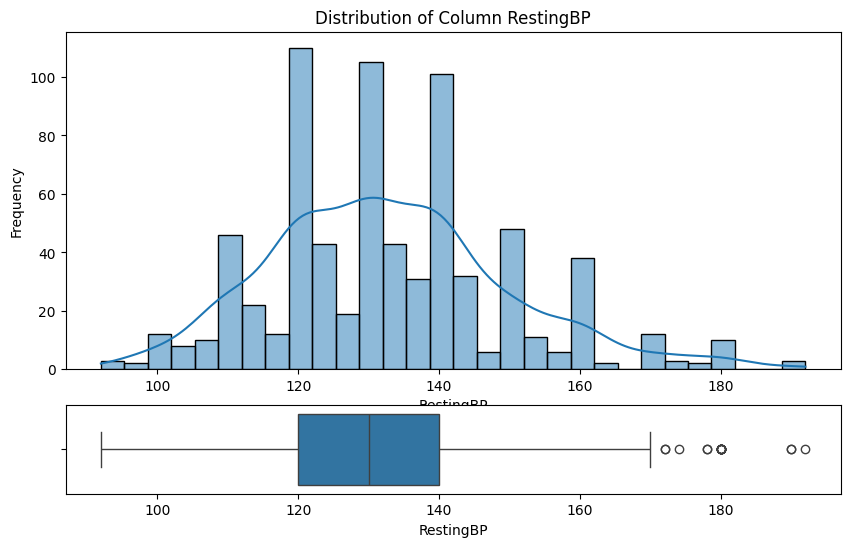

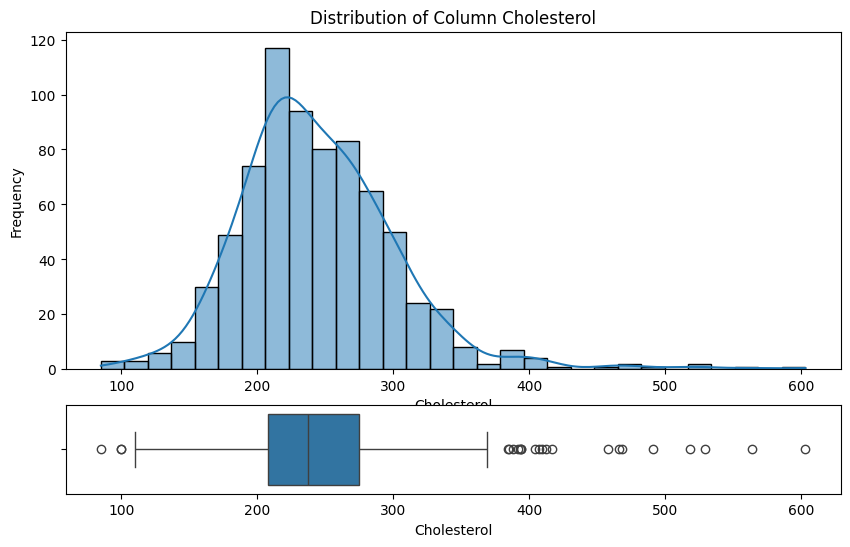

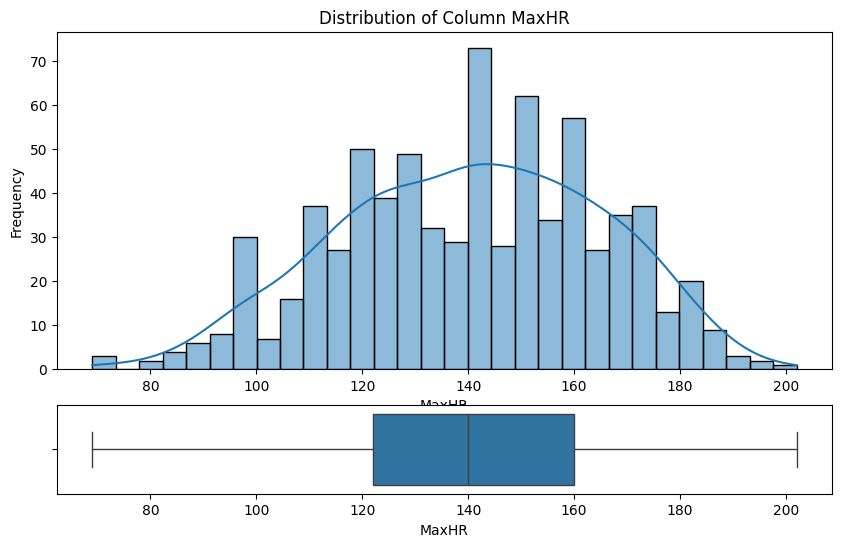

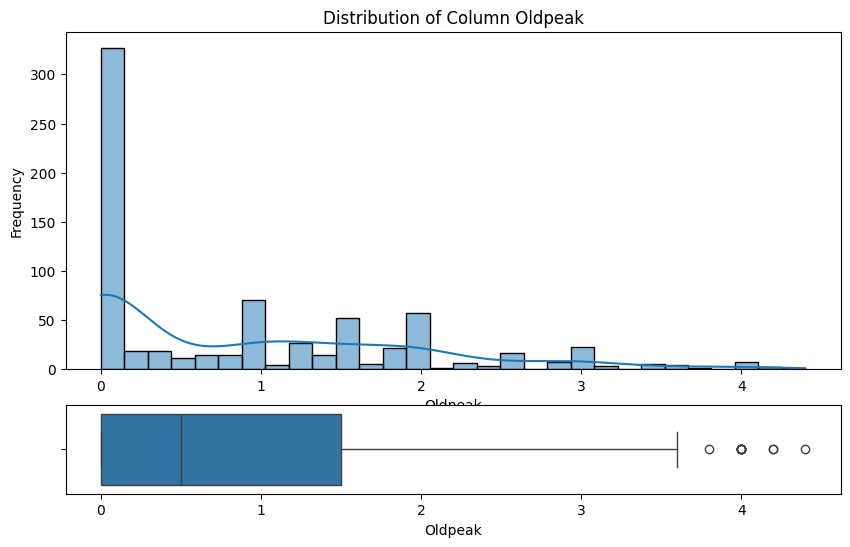

In [25]:
check_distr_outliers(heart_df_cleaned,'Age')
check_distr_outliers(heart_df_cleaned,'RestingBP')
check_distr_outliers(heart_df_cleaned,'Cholesterol')
check_distr_outliers(heart_df_cleaned,'MaxHR')
check_distr_outliers(heart_df_cleaned,'Oldpeak')

 # EDA - Feature Engineering


## Check Gaussian Distribution

In [26]:
def check_outliers(df, column):
  print("Skewness:", df[column].skew())
  print("Kurtosis:", df[column].kurt())
  if abs(df[column].skew()) < 0.5:
      print("The data is approximately symmetric (Gaussian-like).\n")
  else:
      print("The data is skewed.\n")

check_outliers(heart_df_cleaned,'Age')
check_outliers(heart_df_cleaned,'RestingBP')
check_outliers(heart_df_cleaned,'Cholesterol')
check_outliers(heart_df_cleaned,'MaxHR')
check_outliers(heart_df_cleaned,'Oldpeak')

Skewness: -0.09797547370424542
Kurtosis: -0.3930817181885118
The data is approximately symmetric (Gaussian-like).

Skewness: 0.528414449972293
Kurtosis: 0.42341975039679136
The data is skewed.

Skewness: 1.2400600473127121
Kurtosis: 4.540875471357095
The data is skewed.

Skewness: -0.1658673289187966
Kurtosis: -0.5623979431929591
The data is approximately symmetric (Gaussian-like).

Skewness: 1.0319188717126033
Kurtosis: 0.31423699571767916
The data is skewed.



In [27]:
df_no_outliers = heart_df_cleaned.copy()


In [28]:
df_no_outliers['Sex'] = df_no_outliers['Sex'].map({'M': 1, 'F': 0})
df_no_outliers['ExerciseAngina'] = df_no_outliers['ExerciseAngina'].map({'Y': 1, 'N': 0})

### Encoding

In [29]:
df_no_outliers.head(2)
print(set(df_no_outliers['HeartDisease']))
print(len(df_no_outliers),df_no_outliers.shape)

{0, 1}
740 (740, 12)


In [30]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse

# Fit and transform the categorical columns
encoded = encoder.fit_transform(df_no_outliers[['ChestPainType', 'RestingECG', 'ST_Slope']])

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['ChestPainType', 'RestingECG', 'ST_Slope']))

# Verify index alignment
assert len(encoded_df) == len(df_no_outliers), "Encoded DataFrame rows don't match the original DataFrame."
encoded_df.index = df_no_outliers.index  # Ensure the indices align

# Add the encoded columns directly to the original DataFrame
df_no_outliers = df_no_outliers.drop(columns=['ChestPainType', 'RestingECG', 'ST_Slope'])  # Drop original categorical columns
df_no_outliers = pd.concat([df_no_outliers, encoded_df], axis=1)  # Combine without reindexing

# Verify the final DataFrame shape
df_no_outliers.head(3)
print(f"Final shape: {df_no_outliers.shape}")

df_encoded = df_no_outliers.copy()

Final shape: (740, 19)


In [31]:
df_encoded.head(3)


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180,0,156,0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [32]:
df_encoded.shape

(740, 19)

In [33]:
set(df_encoded['HeartDisease'])

{0, 1}

In [34]:
y = df_encoded['HeartDisease']

In [35]:
X = df_encoded.drop('HeartDisease', axis=1,inplace=False)
X.head(2)

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180,0,156,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Splitting, Standarizing, Normalizing, Training, Fitting and Evaluating Models

In [52]:
def compare_algorithms(X, y, test_size=0.3, val_size=0.5, random_state=42):
    """
    Compare multiple supervised learning algorithms on a binary classification task.

    Parameters:
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target variable (binary classification).
        test_size (float): Proportion of data for test and validation combined.
        val_size (float): Proportion of test/validation data used for validation.
        random_state (int): Random state for reproducibility.

    Returns:
        pd.DataFrame: Performance comparison table for each algorithm.
    """
    # Step 1: Split into Train + Temp (Validation + Test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state,stratify=y)

    # Step 2: Split Temp into Validation and Test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state,stratify=y_temp)


    # Normalization: Scale features to range [0, 1]
    min_max_scaler = MinMaxScaler()
    X_train_normalized = min_max_scaler.fit_transform(X_train)
    X_val_normalized = min_max_scaler.transform(X_val)

    # Standardization: Scale features to zero mean and unit variance
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_val_scaled = standard_scaler.transform(X_val)


    # Base Algorithms
    algorithms = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTreeClassifier': DecisionTreeClassifier(random_state=random_state, max_depth=3,min_samples_split=5,min_samples_leaf=3),
        'RandomForestClassifier': RandomForestClassifier(random_state=random_state,max_depth=10, min_samples_split=5,n_estimators=20),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'SVC': SVC(probability=True, random_state=random_state),  # Requires scaling for optimal performance
        'GaussianNB': GaussianNB(),

        'GradientBoostingClassifier': GradientBoostingClassifier(random_state=random_state), # for small datasets
        'AdaBoostClassifier': AdaBoostClassifier(n_estimators=50, random_state=random_state,algorithm='SAMME'), # combine week classifiers in sequential manner
        #'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state), # with regularization to prevent overfitting suport missing val
        #'LGBMClassifier': LGBMClassifier(random_state=random_state), #small and large datasets
        #'CatBoostClassifier': CatBoostClassifier(verbose=0, random_state=random_state) , #small datasets and handles categorical efficiently
    }

    # Add Ensemble Techniques
    # Bagging
    algorithms['Bagging DT'] = BaggingClassifier(
        estimator=algorithms['DecisionTreeClassifier'],
        n_estimators=10,
        random_state=random_state
    )
    algorithms['Bagging RF'] = BaggingClassifier(
        estimator=algorithms['RandomForestClassifier'],
        n_estimators=10,
        random_state=random_state
    )
    algorithms['Bagging KNNs'] = BaggingClassifier(
        estimator=algorithms['KNeighborsClassifier'],
        n_estimators=10,
        random_state=random_state
    )
    # Stacking
    stacking_base_models = [
        ('dt', algorithms['DecisionTreeClassifier']),
        ('rf', algorithms['RandomForestClassifier']),
        ('gb', algorithms['GradientBoostingClassifier']),
        ('svc', algorithms['SVC']),
        ('knn', algorithms['KNeighborsClassifier']),
        ('nb', algorithms['GaussianNB']),

    ]
    algorithms['Stacking'] = StackingClassifier(
        estimators=stacking_base_models,
        final_estimator=algorithms['LogisticRegression'],
        cv=5 # crossvalidation
    )

    # Step 3: Evaluate each algorithm
    performance = []
    for name, model in algorithms.items():
        # Use scaled data for models that require it
        if name in ['KNeighborsClassifier', 'SVC']: # Scaling only applied to KNN and SVC
            model.fit(X_train_scaled, y_train)
            y_train_pred = model.predict(X_train_scaled)
            y_val_pred = model.predict(X_val_scaled)
            y_val_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None
        else:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
        # Calculate performance metrics
        # Training Metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred)

        # Validation Metrics
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)

        # Cross-Validation Scores
        if name in ['KNeighborsClassifier', 'SVC']:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

        performance.append({
            'Model': name,
            'Train Accuracy': train_accuracy,
            'Train F1 Score': train_f1,
            #'Train Precision': train_precision,
            #'Train Recall': train_recall,

            'Validation Accuracy': val_accuracy,
            'Validation F1 Score': val_f1,
            #'Validation Precision': val_precision,
            #'Validation Recall': val_recall,

            'Cross-Validation F1 Mean': cv_scores.mean(),
            'Cross-Validation F1 Std': cv_scores.std(),

            'Likely overfitting': (True if abs(train_f1-val_f1)>=0.05 else False,round((train_f1-val_f1),3)),


        })

    # Convert to DataFrame for better visualization
    performance_df = pd.DataFrame(performance).sort_values(by=['Validation F1 Score'], ascending=False)

    return performance_df

results = compare_algorithms(X, y)
print("Performance Comparison Table:")
results


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Performance Comparison Table:


,Model,Train Accuracy,Train F1 Score,Validation Accuracy,Validation F1 Score,Cross-Validation F1 Mean,Cross-Validation F1 Std,Likely overfitting
6,GradientBoostingClassifier,0.967181,0.965517,0.891892,0.888889,0.857499,0.039505,"(True, 0.077)"
8,Bagging DT,0.874517,0.871795,0.882883,0.878505,0.855907,0.021404,"(False, -0.007)"
11,Stacking,0.936293,0.933333,0.882883,0.878505,0.866574,0.050101,"(True, 0.055)"
9,Bagging RF,0.940154,0.937626,0.873874,0.867925,0.856027,0.046813,"(True, 0.07)"
3,KNeighborsClassifier,0.886100,0.880808,0.864865,0.854369,0.847493,0.044014,"(False, 0.026)"
1,DecisionTreeClassifier,0.862934,0.853608,0.864865,0.851485,0.824888,0.028170,"(False, 0.002)"
2,RandomForestClassifier,0.957529,0.955823,0.855856,0.849057,0.849295,0.039262,"(True, 0.107)"
7,AdaBoostClassifier,0.886100,0.880808,0.855856,0.846154,0.852396,0.043248,"(False, 0.035)"
0,LogisticRegression,0.866795,0.862275,0.846847,0.841121,0.841225,0.034782,"(False, 0.021)"
4,SVC,0.915058,0.910569,0.846847,0.828283,0.855006,0.022394,"(True, 0.082)"


Hungarian: [Hungarian source ](https://archive.ics.uci.edu/dataset/45/heart+disease)
